# Answer to graded assignment 2 in DTE-2501 (AI Methods and Applications) about ensemble methods by Abdullah Karagøz

## 1. Bootstrapping

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from math import pi
from math import exp
from math import log
from math import fsum
import platform
platform.architecture()
import random

### Naive Bayes Classifier

In [2]:
# Naive Bayes Classifier
class NaiveBayesClassifier():
    """
    This is a class for classification using Gaussian Naive Bayes classification where attributes
    are numerical.
      
    Attributes:
        train_set (Pandas Dataframe): the training dataset means, stds and other values are based on
        mean_values (list): contains mean values of all attributes for each class.
        std_values (list): contains standard deviation values of all attribtuets for each class
        prior_class_probabilities (list): contains prior class probabilities for each class
        nr_of_classes (int): number of classes the dataset has
        nr_of_attributes (int): number of attributes (columns) the dataset has
        proba (list): probabilities of the prediction from test set
        preds (list): predictions from test set
    """
    def __init__(self):
        """
        Initializing the NaiveBayesClassifier.
        """
        self.train_set = list()
        self.__mean_values = list()
        self.__std_values =  list()
        self.__prior_class_probabilities =  list()
        self.__nr_of_classes = 0
        self.__nr_of_attributes = 0
        self.__proba = list() # Output of class probabilities
        self.__preds = list() # Output of predictions
        self.__trained = False # Trained flag
        
        
    def fit(self, train_set):
        """
        Training the classifier.
        
        Initializing mean values, std values, prior probabilites, number of classes and attributes.
        
        Parameters:
            train_set (Pandas Dataframe): training samples where classes are 
                integers starting from 0, saved under last column.
        """
        self.train_set = train_set
        
        # if not in ensemble, we calculate these values
        self.__nr_of_classes=train_set.groupby(train_set.iloc[:,-1]).ngroups
        self.__nr_of_attributes=len(train_set.iloc[0,:-1])
        
        # Here we keep mean, std and prior class probability values
        self.__mean_values = list()
        self.__std_values = list()
        self.__prior_class_probs = list()
        
        # calculating mean, std values and prior probabilities of classes
        for i in range(self.__nr_of_classes):
            class_values = train_set[train_set.iloc[:,-1] == i] # All values for certain class
            prior_class_prob = len(class_values) / len(train_set)
            self.__prior_class_probs.append(prior_class_prob)
            mean_values = list()
            std_values = list()   
            for j in range(self.__nr_of_attributes):
                values = class_values.iloc[:,j].values.tolist()
                std, mean = self.__std_and_mean(values)
                mean_values.append(mean)
                std_values.append(std)
            self.__mean_values.append(mean_values)
            self.__std_values.append(std_values)
        
        self.__trained = True


    def __mean(self, val_list):
        """
        Getting the mean of the values.
        
        Parameters:
            val_list (int): list of values.
        
        returns:
            float: mean of the values.
        """
        return fsum(val_list) / len(val_list)
    
    
    def __std_and_mean(self, val_list):
        """
        Getting the mean and standard deviation of the values
        
        Parameters:
            val_list (int): list of values
        
        returns:
            (float, float): standard deviation and mean of the values
        """
        mu = self.__mean(val_list)
        std = sqrt(fsum([(x - mu)**2 for x in val_list]) / (len(val_list)-1))
        return std, mu
        
    
    def __gaussian_pdf(self, x, mu, sd, log_prob):
        """
        Calculating the probability with Gaussian PDF.
        
        Parameters:
            x (float): the value to claculated probability of with Gaussian PDF
            mu (float): mean value to be used in Gaussian PDF
            sd (float): standard devaition value to be used in Gaussian PDF
            log_prob (bool): set to True to use logarithm of the probability in claculations.
        
        Returns:
            (float): the probability value of x using Gaussian PDF.    
        """
        if log_prob:
            return_val = (-0.5*((x-mu)/sd)**2) - log(sd*sqrt(2*pi))
        else:
            return_val = (1 / (sd*sqrt(2*pi))) * exp(-0.5*((x-mu)/sd)**2)
        return return_val
    
    
    
    # Predicting classes on the test set
    def predict(self, test_set, log_prob = False):
        """
        Predicts the class of all samples in a test set
        
        Parameters:
            test_set (Pandas Dataframe): samples to be tested, where the class is in the last column, and
                other columns contain attribute values.
            log_prob (bool): set to True if you want to use logarithm of probabilities in calculations.
            
        Returns:
            list: predicted class labels.
        """
        if not self.__trained:
            raise Exception("The classifier is not trained yet, run fit() function by passing the training set.")
        probabilities = self.predict_proba(test_set, log_prob) # Getting the probabilities first
        
        self.__preds = [probs.index(max(probs)) for probs in probabilities] # Doing argmax for each probability
        
        return self.__preds

    
    
    # Predicting probabilities of the test set
    def predict_proba(self, test_set, log_prob=False):
        """
        Compute the probabilities of classes of all samples in a test set
        
        Parameters:
            test_set (Pandas Dataframe): samples to be tested, where the class is in the last column, and
                other columns contain attribute values.
            log_prob (bool): set to True if you want to use logarithm of probabilities in calculations.
            
        Returns:
            list: weighted average probability for each class per sample.
        """
        if not self.__trained:
            raise Exception("The classifier is not trained yet, run fit() function by passing the training set.")
        
        # Dividing the data into attributes and classes (Desired outputs)
        X_test = test_set.iloc[:, :-1].values.tolist()
        y_test = test_set.iloc[:, -1].values.tolist()
        
        probabilities = list()
        for x, y in zip(X_test, y_test):
            prob = self.probs_row(x, log_prob) # Calculating probabilities for each row
            probabilities.append(prob)
        self.__proba = probabilities
        
        return probabilities
    
    
    # Returning cache of probabilities saved
    def get_proba():
        """
        Get the computed probabilities cache.
        """
        if self.__proba:
            return self.__proba
        else:
            raise Exception("The probabilities are empty")
    
    
    # Calculating probabilities for each row
    def probs_row(self, row, log_prob = False):
        """
        Compute the probability of class for each sample.
        
        Parameters:
            row (list): a list of attributes of the class, all attributes must be numerical.
            log_prob (bool): Set to True if you want to use logarithm of probabilities in calculations.
        Returns:
            list: weighted probabilities of each label.
        """
        probs = self.__nr_of_classes*[0]
        
        if log_prob:
            for i in range(self.__nr_of_classes):
                probs[i] = 0 if self.__prior_class_probs[i] == 0 else log(self.__prior_class_probs[i])
                for j in range(len(row)):
                    probs[i] += self.__gaussian_pdf(row[j], self.__mean_values[i][j], self.__std_values[i][j], log_prob)
                probs[i] = exp(probs[i]) # Converting back from log(prob) to prob
        
        else: 
            for i in range(self.__nr_of_classes):
                probs[i] = self.__prior_class_probs[i]
                for j in range(len(row)):
                    probs[i] *= self.__gaussian_pdf(row[j], self.__mean_values[i][j], self.__std_values[i][j], log_prob)
                    
        probs = [x / fsum(probs) for x in probs] # Converting to real probabilities
        return probs
        
        

### Ensembled Classifier

In [3]:
class EnsembledNBClassifier():  
    """
    This is a class for classification using by ensembling Gaussian Naive Bayes classifiers where attributes
    are numerical. It's using bagging method.
    
    Attributes:
        classifiers (list): where all NaiveBayesClassifier objects are kept
        proba (list): probabilities of the prediction from test set
        preds (list): predictions from test set
    """
    
    
    def __init__(self, nr_of_classifiers):
        """
        Initializing the NaiveBayesClassifier.
        
        Parameters:
            nr_of_classifiers (int): number of classifiers which the ensemble method will have.
        """
        self.classifiers = list()
        for i in range(nr_of_classifiers):
            self.classifiers.append(NaiveBayesClassifier())
        self.__proba = list()
        self.__preds = list()
        self.__trained = False # Trained flag
    
    
    
    def fit(self, train_set, seed=None):
        """
        Training all classifiers.
        
        Initializing mean values, std values, prior probabilites, number of classes and attributes.
        
        Parameters:
            train_set (Pandas Dataframe): training samples where classes are 
                integers starting from 0, saved under last column.
            seed (int): Set random seed while training to make it reproducible
        """
        random.seed(seed)
        # Bootstrapping and training classifiers
        for cl in self.classifiers:  
            random_state = random.randint(1,4096)        
            bag = train_set.sample(frac=1, replace=True, random_state=random_state).reset_index(drop=True)
            cl.fit(bag)
        
        self.__trained = True
    
        
    
    def predict(self, test_set, log_prob = False, majority_vote = False):
        """
        Predicts the class of all samples in a test set using aggregated value or majoriy voting.
        
        Parameters:
            test_set (Pandas Dataframe): samples to be tested, where the class is in the last column, and
                other columns contain attribute values.
            log_prob (bool): set to True if you want to use logarithm of probabilities in calculations.
            majority_vote (bool): set to True if you want to use majority voting in prediction.
            
        Returns:
            list: predicted class labels.
        """
        if  not self.__trained:
            raise Exception("The classifier is not trained yet, run fit() function by passing the training set.")
        
        predictions = list()
        
        
        # Majority voting method
        if majority_vote:
            all_probs = self.__get_all_probs(test_set, log_prob)
            for probs in all_probs:
                preds = [prob.index(max(prob)) for prob in probs]
                pred = max(set(preds), key = lambda x: preds.count(x) + 0.1*random.random())
                predictions.append(pred)
        
        else:
            # Aggregated probabilities
            agg_probs = self.predict_proba(test_set, log_prob)
            predictions = [probs.index(max(probs)) for probs in agg_probs]
        
        self.__preds = predictions
        return self.__preds
            

    
    def predict_proba(self, test_set, log_prob = False):
        """
        Compute the probabilities of classes of all samples in a test set, using aggregated value.
        
        Parameters:
            test_set (Pandas Dataframe): samples to be tested, where the class is in the last column, and
                other columns contain attribute values.
            log_prob (bool): set to True if you want to use logarithm of probabilities in calculations.
            
        Returns:
            list: weighted average probability for each class per sample.
        """
        if not self.__trained:
            raise Exception("The classifier is not trained yet, run fit() function by passing the training set.")
        
        all_probs = self.__get_all_probs(test_set, log_prob)
        
        
        probabilities = list()
        
        # Using aggregated probabilities
        for probs in all_probs:
            # Arithmetic mean of all probabilities
            agg_probs = [fsum(x)/len(probs) for x in zip(*probs)]
            probabilities.append(agg_probs)

        self.__proba = probabilities
        return self.__proba
    
    
    def __get_all_probs(self, test_set, log_prob):
        """
        A helper function to get all weighted average probability for each 
        class per sample for each classifier.
        
        Parameters:
            test_set (Pandas Dataframe): samples to be tested, where the class is in the last column, and
                other columns contain attribute values.
                
            log_prob (bool): set to True if you want to use logarithm of probabilities in calculations.
            
        Returns:
            list: weighted average probability for each class per sample for each classifier.
        """
        # splitting the data
        X_test = test_set.iloc[:, :-1].values.tolist()
        y_test = test_set.iloc[:, -1].values.tolist()
        
        all_probs = list()
        
        for x, y in zip(X_test, y_test):
            preds = list()
            probs = list()

            for cl in self.classifiers:
                prob = cl.probs_row(x, log_prob) # predict each row
                probs.append(prob)
            
            all_probs.append(probs)
        return all_probs



### Metrics class (static functions)

In [4]:
class Metrics():
    """
    This is a class to compute performace metrics of classifiers. 
    It has only static functions.
    """
    
    def get_cel(y_true, y_proba):
        """
        Computing mean Cross Entropy Loss
        
        Parameters:
            y_true (list): desired values from test set.
            y_proba (list): weighted average probability for each class per sample.
            
        Returns:
            float: Cross Entropy Loss value
        """
        cel = 0
        for probs, y in zip(y_proba, y_true):
            cel -= log(probs[y]) # Cross entropy loss
        
        cel = cel/len(y_true)
        
        return cel
    
    
    def get_accuracy(y_true, y_pred):
        """
        Computing accuracy
        
        Parameters:
            y_true (list): desired values from test set.
            y_proba (list): weighted average probability for each class per sample.
            
        Returns:
            float: Accuracy value.
        """
        corrects = 0
        for pred, y in zip(y_pred, y_true):
            corrects += (int(y == pred))
        
        accuracy = corrects / len(y_true)
        return accuracy
    
    
    def get_f1(y_true, y_pred, labels, average='macro'):
        """
        Computing F1 score
        
        Parameters:
            y_true (list): desired values from test set.
            y_proba (list): weighted average probability for each class per sample.
            labels (int): How many labels does the class have
            average: set to 'macro' to return mean F1 score, 'micro' to return F1 score for each class.
            
        Returns:
            float or list: mean F1 score or F1 score for each class
        """
        precisions = labels*[0]
        recalls = labels*[0]
        conf_matr = [[0]*labels for x in range(labels)]
        
        f1 = labels*[0] # F1 scores for each class
        tp = labels*[0] # True positives
        fn = labels*[0] # False negatives
        fp = labels*[0] # False positives
        
        
        # Calculating TP, TN, FP, FN
        for pred, y in zip(y_pred, y_true):
            for i in range(labels):
                if i == pred == y:
                    tp[i] += 1
                elif i == pred != y:
                    fp[i] += 1
                elif i != pred and i == y:
                    fn[i] += 1
                        
        # Calculating F1 scores
        for i in range(labels):
            precisions[i] = tp[i] / (tp[i] + fp[i])
            recalls[i] = tp[i] / (tp[i] + fn[i])
            f1[i] = (2*precisions[i]*recalls[i]) /  (precisions[i]+recalls[i])
        
        
        if average=='macro': # Return mean f1 score
            mean_f1 = fsum(f1)/labels
            return mean_f1
        else:
            return f1 # Return f1 for all classes
            
        
        

    
    
    

## Testing and validation

### Testing function

In [5]:
# Testing n times and see average f1, accuracy and cel
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from tabulate import tabulate
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def testing(dataset, nr_of_classifiers = 10, train_test_split = 0.8, n=1, seed=None, log_prob=True):
    """
    Function to test and print performance metrics on a datasets.
    
    This function tests Gaussian Naive Bayes and ensemble methods with different methods N times,
    and compares F1, accuracy and cross entropy loss between them. It prints the results using tabulate table.
    The tests are:
    
    * Single GNB from Sklearn
    * Single GNB classifier without using log probs.
    * Single GNB with using log probs
    * Ensemble from Sklearn
    * Ensemble using aggregated probabilities
    * Ensemble using majority voting (cross entropy loss not available)

    Parameters:
        dataset (Pandas Dataframe): the dataset to train and test on.
        nr_of_classifiers (int): Nr of classifiers ensemble methods will use
        train_test_split (float): The rate of the dataset that will be used for training.
        n (int): Number of tests.
        seed (int): Random state seed.
        log_prob (bool): Whether to use log prob or not on ensemble methods other than Sklearn.
     """
    
    
    nr_of_classes = dataset.groupby(dataset.iloc[:,-1]).ngroups

    # All will be list of 3 lists, each of sub-list will be for accyracy, F1 and Cel.
    tests_single_skl = [[] for i in range(3)]
    tests_single = [[] for i in range(3)]
    tests_single_log = [[] for i in range(3)]

    tests_ensemble_skl = [[] for i in range(3)]
    tests_ensemble_voting = [[] for i in range(3)]
    tests_ensemble_aggr = [[] for i in range(3)]


    for i in range(n):
        # Shuffle and split data into training 80% and testing 20%
        train_set = dataset.sample(frac=train_test_split, random_state=seed)
        test_set = dataset.drop(train_set.index)
        train_set.reset_index(drop=True, inplace=True)
        test_set.reset_index(drop=True, inplace=True)

        y_true = test_set.iloc[:,-1].values.tolist()

        # Prepare the Numpy array which will be used in Sklearn libraries
        X_train = train_set.iloc[:,:-1].to_numpy()
        y_train = train_set.iloc[:,-1].to_numpy().astype('int')
        X_test = test_set.iloc[:,:-1].to_numpy()
        y_test = test_set.iloc[:,-1].to_numpy().astype('int')

        # From Sci-kit learn
        nbc = GaussianNB()
        nbc.fit(X_train, y_train)

        y_pred = nbc.predict(X_test)
        Y_proba = nbc.predict_proba(X_test)

        tests_single_skl[0].append(Metrics.get_accuracy(y_true, y_pred))
        tests_single_skl[1].append(Metrics.get_f1(y_true, y_pred, nr_of_classes))
        tests_single_skl[2].append(Metrics.get_cel(y_true, Y_proba))

        # Single classifier initialize
        nbc = NaiveBayesClassifier()
        nbc.fit(train_set)

        # Single classifier without using log
        y_pred = nbc.predict(test_set)
        Y_proba = nbc.predict_proba(test_set)

        tests_single[0].append(Metrics.get_accuracy(y_true, y_pred))
        tests_single[1].append(Metrics.get_f1(y_true, y_pred, nr_of_classes))
        tests_single[2].append(Metrics.get_cel(y_true, Y_proba))
        

        # Single classifier with using log
        y_pred = nbc.predict(test_set, log_prob=True)
        Y_proba = nbc.predict_proba(test_set, log_prob=True)

        tests_single_log[0].append(Metrics.get_accuracy(y_true, y_pred))
        tests_single_log[1].append(Metrics.get_f1(y_true, y_pred, nr_of_classes))
        tests_single_log[2].append(Metrics.get_cel(y_true, Y_proba))


        # Initializing and training ensemble of Sci-kit Learn
        ens_nbc = BaggingClassifier(GaussianNB(), n_estimators=nr_of_classifiers, random_state=seed)
        ens_nbc.fit(X_train, y_train)


        y_pred = ens_nbc.predict(X_test)
        Y_proba = ens_nbc.predict_proba(X_test)

        tests_ensemble_skl[0].append(Metrics.get_accuracy(y_true, y_pred))
        tests_ensemble_skl[1].append(Metrics.get_f1(y_true, y_pred, nr_of_classes))
        tests_ensemble_skl[2].append(Metrics.get_cel(y_true, Y_proba))


        #Initializing and training ensemble classifier I built
        ens_nbc = EnsembledNBClassifier(nr_of_classifiers)
        ens_nbc.fit(train_set, seed)

        # Ensembled classifier using majority vote
        y_pred = ens_nbc.predict(test_set, majority_vote = True, log_prob=log_prob)

        tests_ensemble_voting[0].append(Metrics.get_accuracy(y_true, y_pred))
        tests_ensemble_voting[1].append(Metrics.get_f1(y_true, y_pred, nr_of_classes))

        # Ensembled classifier using aggregated probabilities
        y_pred = ens_nbc.predict(test_set, log_prob=log_prob)
        Y_proba = ens_nbc.predict_proba(test_set, log_prob=log_prob)

        tests_ensemble_aggr[0].append(Metrics.get_accuracy(y_true, y_pred))
        tests_ensemble_aggr[1].append(Metrics.get_f1(y_true, y_pred, nr_of_classes))
        tests_ensemble_aggr[2].append(Metrics.get_cel(y_true, Y_proba))
        


    # Calculating means from the lists

    mean_results = [[] for x in range(6)]

    mean_results[0].append('Single classifier Sklearn')
    mean_results[1].append('Single classifier')
    mean_results[2].append('Single classifier with log prob')
    mean_results[3].append('Ensemble classifier Sklearn')
    mean_results[4].append('Ensemble classifier with majority voting')
    mean_results[5].append('Ensemble classifier with aggregated probabilities')

    for i in range(3):
        mean_results[0].append(fsum(tests_single_skl[i]) / n)
        mean_results[1].append(fsum(tests_single[i]) / n)
        mean_results[2].append(fsum(tests_single_log[i]) / n)
        mean_results[3].append(fsum(tests_ensemble_skl[i]) / n)
        mean_results[4].append(fsum(tests_ensemble_voting[i]) / n)
        mean_results[5].append(fsum(tests_ensemble_aggr[i]) / n)
    
    mean_results[4][3] = ('N/A')

    comparison_table = tabulate(mean_results, 
                                headers=['Accuracy', 'F1 Score', 'Cross Entropy Loss'], floatfmt=".4f")
    

    print(comparison_table)


### Function to plot performance of ensembled classes

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec



def plotting_ensemble(dataset, nr_of_classifiers, train_test_split, seed=None, log_prob=True):
    """
    Function to test and plot results of ensemble methods with different nr of classifiers.
    
    This function tests performance of ensemble methods with  Gaussian Naive Bayes classifier,
    plots the results of the test from 1 to N number of classifiers. The performance metrics are,
    F1, accuracy and cross entropy loss.
    
    * Ensemble from Sklearn
    * Ensemble using aggregated probabilities
    * Ensemble using majority voting (cross entropy loss not available)

    Parameters:
        dataset (Pandas Dataframe): the dataset to train and test on.
        nr_of_classifiers (int): Max nr of classifiers ensemble methods will use.
        train_test_split (float): The rate of the dataset that will be used for training.
        seed (int): Random state seed.
        log_prob (bool): Whether to use log prob or not on ensemble methods other than Sklearn.
     """
    
    nr_of_classes = dataset.groupby(dataset.iloc[:,-1]).ngroups
    
    # Shuffle and split data into training 80% and testing 20%
    train_set = dataset.sample(frac=train_test_split, random_state=seed)
    test_set = dataset.drop(train_set.index)
    train_set.reset_index(drop=True, inplace=True)
    test_set.reset_index(drop=True, inplace=True)

    y_true = test_set.iloc[:,-1].values.tolist()

    # Prepare the Numpy array which will be used in Sklearn libraries
    X_train = train_set.iloc[:,:-1].to_numpy()
    y_train = train_set.iloc[:,-1].to_numpy().astype('int')
    X_test = test_set.iloc[:,:-1].to_numpy()
    y_test = test_set.iloc[:,-1].to_numpy().astype('int')


    f1_results = [[] for i in range(3)]
    cel_results = [[] for i in range(3)]
    acc_results = [[] for i in range(3)]
    
    for n in range(1, nr_of_classifiers+1):
        # Initializing and training ensemble of Sci-kit Learn
        ens_nbc = BaggingClassifier(GaussianNB(), n_estimators=n, random_state=seed)
        ens_nbc.fit(X_train, y_train)

        y_pred = ens_nbc.predict(X_test)
        Y_proba = ens_nbc.predict_proba(X_test)

        acc_results[0].append(Metrics.get_accuracy(y_true, y_pred))
        f1_results[0].append(Metrics.get_f1(y_true, y_pred, nr_of_classes))
        cel_results[0].append(Metrics.get_cel(y_true, Y_proba))


        #Initializing and training ensemble classifier I built
        ens_nbc = EnsembledNBClassifier(n)
        ens_nbc.fit(train_set, seed)
        
        # Ensembled classifier using aggregated probabilities
        y_pred = ens_nbc.predict(test_set, log_prob=log_prob)
        Y_proba = ens_nbc.predict_proba(test_set, log_prob=log_prob)

        acc_results[1].append(Metrics.get_accuracy(y_true, y_pred))
        f1_results[1].append(Metrics.get_f1(y_true, y_pred, nr_of_classes))
        cel_results[1].append(Metrics.get_cel(y_true, Y_proba))


        
        # Ensembled classifier using majority vote
        y_pred = ens_nbc.predict(test_set, majority_vote = True, log_prob=log_prob)

        acc_results[2].append(Metrics.get_accuracy(y_true, y_pred))
        f1_results[2].append(Metrics.get_f1(y_true, y_pred, nr_of_classes))

     
    width = 0.25
    x_ticks = [x+1 for x in range(nr_of_classifiers)]
    x_1 = [x+1 for x in range(nr_of_classifiers)]
    x_2 = [x+1+width for x in range(nr_of_classifiers)]
    x_3 = [x+1+width*2 for x in range(nr_of_classifiers)]
    
    
    fig = plt.figure(figsize=(15,10))
    
    # Create 2x2 sub plots
    gs = gridspec.GridSpec(2, 2)

    
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.bar(x_1, acc_results[0], width=width, label='Sklearn')
    ax1.bar(x_2, acc_results[1], width=width, label='Aggregation')
    ax1.bar(x_3, acc_results[2], width=width, label='Majority voting')
    ax1.set_ylabel("Accuracy")
    ax1.set_xlabel("Nr of estimators")
    ax1.set_title("Accuracy")
    ax1.grid()
    ax1.set_ylim(min(acc_results[0] + acc_results[1] + acc_results[2]) - 0.1)

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.bar(x_1, f1_results[0], width=width, label='Sklearn')
    ax2.bar(x_2, f1_results[1], width=width, label='Aggregation')
    ax2.bar(x_3, f1_results[2], width=width, label='Majority voting')
    ax2.set_ylabel("F1 score")
    ax2.set_xlabel("Nr of estimators")
    ax2.set_title("F1 score")
    ax2.grid()
    ax2.set_ylim(min(f1_results[0] + f1_results[1] + f1_results[2]) - 0.1)

    ax3 = fig.add_subplot(gs[1, 0])
    ax3.bar(x_1, cel_results[0], width=width, label='Sklearn')
    ax3.bar(x_2, cel_results[1], width=width, label='Aggregation')
    ax3.set_ylabel("CEL")
    ax3.set_xlabel("Nr of estimators")
    ax3.set_title("Cross Entropy Loss")
    ax3.grid()
    ax3.set_ylim(min(cel_results[0] + cel_results[1]) - 0.1)
    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(0.5, 0.1, 0.1, 0.4))




    fig.suptitle('Performance of ensemble methods', fontsize=16)
    plt.show()
    

In [7]:
nr_of_tests = 1 # Nr of tests to make
nr_of_classifiers = 10
train_test_split = 0.8
seed = 42
random.seed(seed)

## Testing some datasets

### Iris Dataset

In [8]:

# Load the data
dataset_iris = pd.read_csv('iris.data', header=None, names=['sepal length', 'sepal width',
                                                     'petal length', 'petal width',
                                                     'class'])

In [9]:
#Assign label to each class
dataset_iris.loc[dataset_iris['class'] == 'Iris-setosa', dataset_iris.columns == 'class'] = 0
dataset_iris.loc[dataset_iris['class'] == 'Iris-versicolor', dataset_iris.columns == 'class'] = 1
dataset_iris.loc[dataset_iris['class'] == 'Iris-virginica', dataset_iris.columns == 'class'] = 2

In [10]:
testing(dataset_iris, nr_of_classifiers, train_test_split, nr_of_tests, seed)

                                                     Accuracy    F1 Score  Cross Entropy Loss
-------------------------------------------------  ----------  ----------  --------------------
Single classifier Sklearn                              0.9333      0.9419  0.17207407709737016
Single classifier                                      0.9333      0.9419  0.16921772115579153
Single classifier with log prob                        0.9333      0.9419  0.16921772115579145
Ensemble classifier Sklearn                            0.9667      0.9710  0.16890942229174077
Ensemble classifier with majority voting               0.9667      0.9710  N/A
Ensemble classifier with aggregated probabilities      0.9667      0.9710  0.1549888161963924


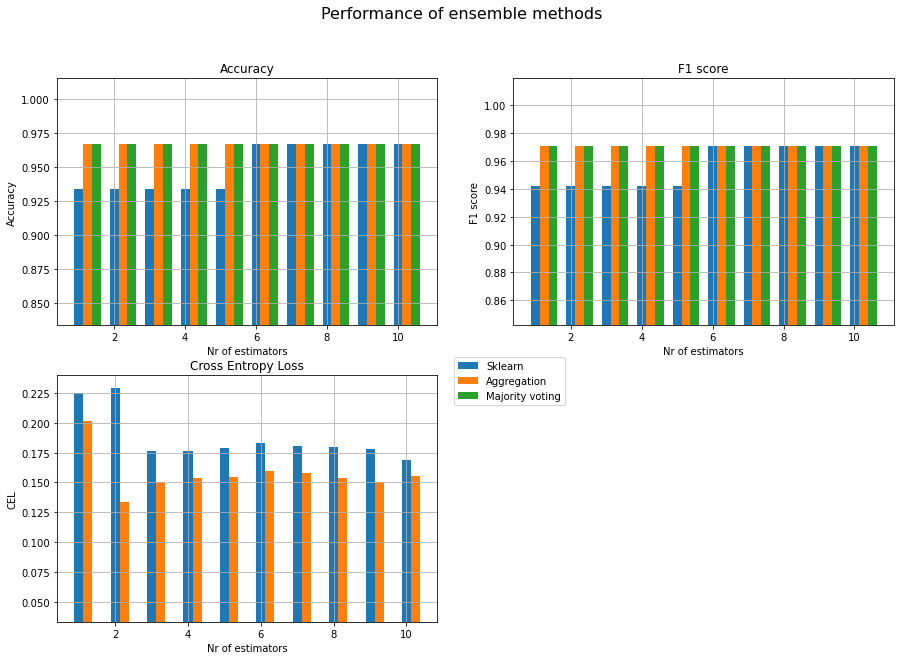

In [11]:
plotting_ensemble(dataset_iris, nr_of_classifiers, train_test_split, seed)

### Pima Indians Diabetes Dataset

In [12]:

# Load the data
dataset_pima = pd.read_csv('pima-indians-diabetes.csv', header=None, names=['Number of times pregnant', 
                                                                        'Plasma glucose concentration a 2 hours in an oral glucose tolerance test',
                                                                        'Diastolic blood pressure (mm Hg)',
                                                                        'Triceps skin fold thickness (mm)',
                                                                        '2-Hour serum insulin (mu U/ml)',
                                                                        'Body mass index (weight in kg/(height in m)^2)',
                                                                        'Diabetes pedigree function',
                                                                        'Age (years)',
                                                                        'class'],)


In [13]:
testing(dataset_pima, nr_of_classifiers, train_test_split, nr_of_tests, seed)

                                                     Accuracy    F1 Score  Cross Entropy Loss
-------------------------------------------------  ----------  ----------  --------------------
Single classifier Sklearn                              0.7403      0.7123  0.5315391668671342
Single classifier                                      0.7403      0.7123  0.5314810010548495
Single classifier with log prob                        0.7403      0.7123  0.5314810010548499
Ensemble classifier Sklearn                            0.7468      0.7231  0.5201376273018627
Ensemble classifier with majority voting               0.7338      0.7064  N/A
Ensemble classifier with aggregated probabilities      0.7273      0.6979  0.5126825847024592


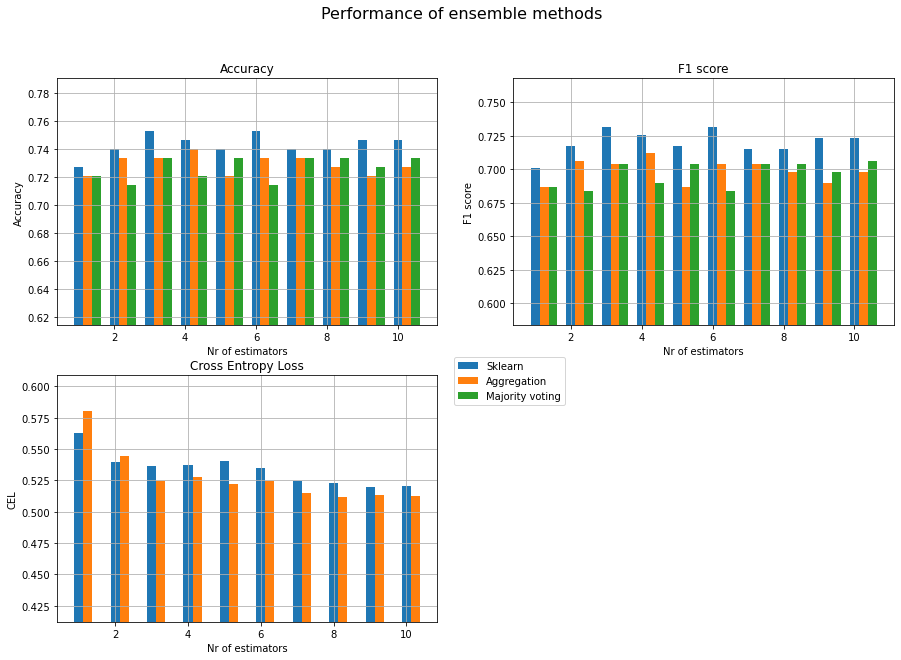

In [14]:
plotting_ensemble(dataset_pima, nr_of_classifiers, train_test_split, seed)

### Sonar dataset and Banknotes set

In [15]:
# Sonar dataset
dataset_sonar = pd.read_csv('sonar.all-data', header=None)

dataset_sonar.iloc[dataset_sonar.iloc[:, -1] == 'R', -1] = 0
dataset_sonar.iloc[dataset_sonar.iloc[:, -1] == 'M', -1] = 1
dataset_sonar

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.0187,0.0346,0.0168,0.0177,0.0393,0.1630,0.2028,0.1694,0.2328,0.2684,...,0.0116,0.0098,0.0199,0.0033,0.0101,0.0065,0.0115,0.0193,0.0157,1
204,0.0323,0.0101,0.0298,0.0564,0.0760,0.0958,0.0990,0.1018,0.1030,0.2154,...,0.0061,0.0093,0.0135,0.0063,0.0063,0.0034,0.0032,0.0062,0.0067,1
205,0.0522,0.0437,0.0180,0.0292,0.0351,0.1171,0.1257,0.1178,0.1258,0.2529,...,0.0160,0.0029,0.0051,0.0062,0.0089,0.0140,0.0138,0.0077,0.0031,1
206,0.0303,0.0353,0.0490,0.0608,0.0167,0.1354,0.1465,0.1123,0.1945,0.2354,...,0.0086,0.0046,0.0126,0.0036,0.0035,0.0034,0.0079,0.0036,0.0048,1


In [16]:
testing(dataset_sonar, nr_of_classifiers, train_test_split, nr_of_tests, seed)

                                                     Accuracy    F1 Score  Cross Entropy Loss
-------------------------------------------------  ----------  ----------  --------------------
Single classifier Sklearn                              0.6190      0.6182  2.5479320257008187
Single classifier                                      0.6190      0.6182  2.540467461696351
Single classifier with log prob                        0.6190      0.6182  2.5404674616963527
Ensemble classifier Sklearn                            0.6190      0.6190  1.9854946795184918
Ensemble classifier with majority voting               0.6190      0.6182  N/A
Ensemble classifier with aggregated probabilities      0.6190      0.6182  1.3611721679868185


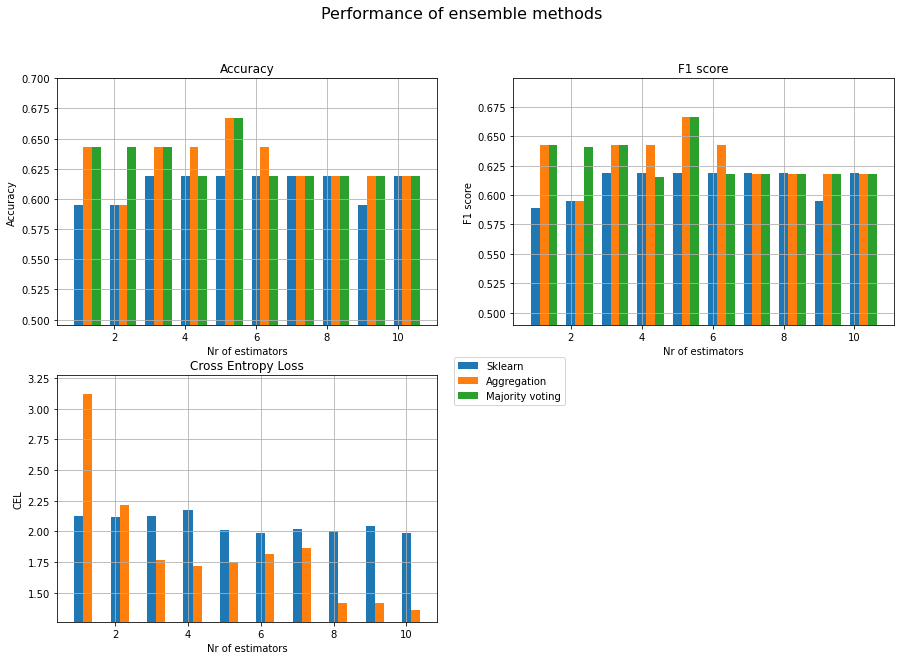

In [17]:
plotting_ensemble(dataset_sonar, nr_of_classifiers, train_test_split, seed)

In [18]:
# Sonar dataset
dataset_banknote = pd.read_csv('data_banknote_authentication.txt', header=None)

dataset_banknote

,0,1,2,3,4
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [19]:
testing(dataset_banknote, nr_of_classifiers, train_test_split, nr_of_tests, seed)

                                                     Accuracy    F1 Score  Cross Entropy Loss
-------------------------------------------------  ----------  ----------  --------------------
Single classifier Sklearn                              0.8467      0.8461  0.32544730637547203
Single classifier                                      0.8467      0.8461  0.32543249662682994
Single classifier with log prob                        0.8467      0.8461  0.32543249662683005
Ensemble classifier Sklearn                            0.8540      0.8535  0.32426631187220595
Ensemble classifier with majority voting               0.8431      0.8426  N/A
Ensemble classifier with aggregated probabilities      0.8467      0.8462  0.32249124490281444


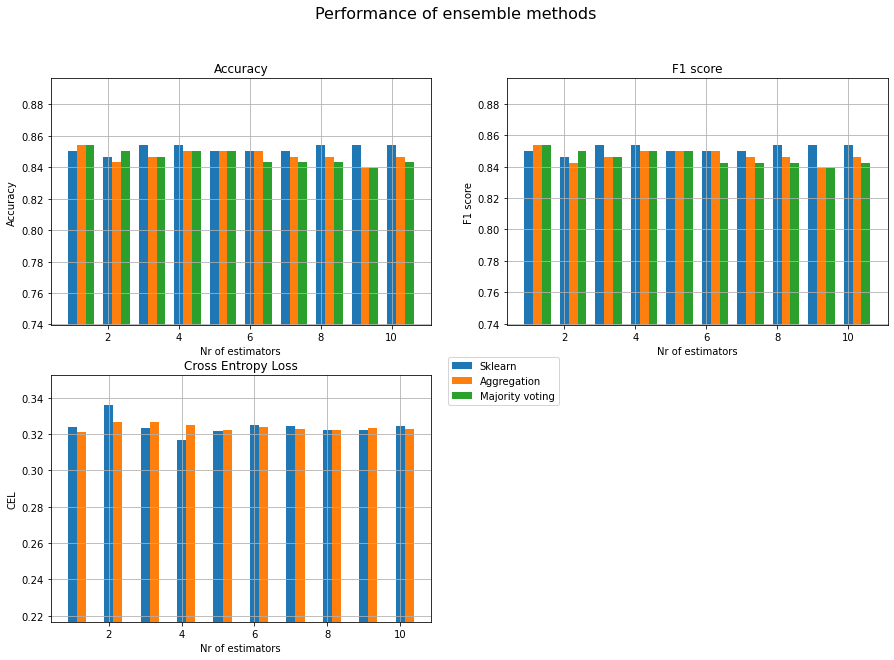

In [20]:
plotting_ensemble(dataset_banknote, nr_of_classifiers, train_test_split, seed)